In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('myData.csv')
y = data[['popularity', 'revenue', 'vote_average', 'vote_count']].values
x = data.drop(columns=['popularity', 'revenue', 'vote_average', 'vote_count'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5233)


In [7]:
def numTextSplit(data):
    numData = data.drop(columns=['text']).values
    textData = data['text'].values
    return numData, textData
x_train_num, x_train_text = numTextSplit(x_train)
x_test_num, x_test_text = numTextSplit(x_test)

In [8]:
import torch
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
def makeInputData(numData, textData, labels, isTrain):
    MAX_LEN = 30
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_text = [tokenizer.tokenize(text) for text in textData]
    ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    textInputs = torch.tensor(ids)
    masks = torch.tensor(attention_masks)
    numInputs = torch.tensor(numData)
    labels = torch.tensor(labels)
    # Select a batch size for training. 
    batch_size = 1

    # Create an iterator of our data with torch DataLoader 
    dataset = TensorDataset(textInputs, masks, numInputs, labels)
    if isTrain:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)
        
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return dataloader



In [11]:
trainLoader = makeInputData(numData=x_train_num, textData=x_train_text, labels=y_train, isTrain=True)
testLoader = makeInputData(numData=x_test_num, textData=x_test_text, labels=y_test, isTrain=False)

del x_train, x_test, x, y, data, x_train_num, x_train_text, x_test_num, x_test_text

In [10]:
import torch
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import torchvision.models
import hiddenlayer as hl
import torch.nn as nn

In [15]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
        self.fc1 = nn.Linear(7, 5)
        self.output = nn.Linear(5,4)
        
    def forward(self, ids, mask, numbers):
        x1 = self.bert(ids, token_type_ids=None, attention_mask=mask)
        x2 = numbers
        x = torch.cat((x1.float(), x2.float()), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.relu(x)
        return x


In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
model = MyModel()

'GeForce MX150'

t_total value of -1 results in schedule not being applied
Epoch:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]

Train loss: 0.04435191011867901


D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:  33%|███████████████████████▋                                               | 1/3 [1:35:53<3:11:47, 5753.53s/it]

Test Loss: 0.03981904156557214
已花時間: 95m 54s
--------------------------------------------------
Train loss: 0.040163474202836905


Epoch:  67%|███████████████████████████████████████████████▎                       | 2/3 [3:13:00<1:36:15, 5775.44s/it]

Test Loss: 0.03631170883697147
已花時間: 193m 0s
--------------------------------------------------
Train loss: 0.037173180536931374


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [4:52:16<00:00, 5845.45s/it]

Test Loss: 0.03456593728156859
已花時間: 292m 16s
--------------------------------------------------
結束訓練
Training complete in 292m 16s


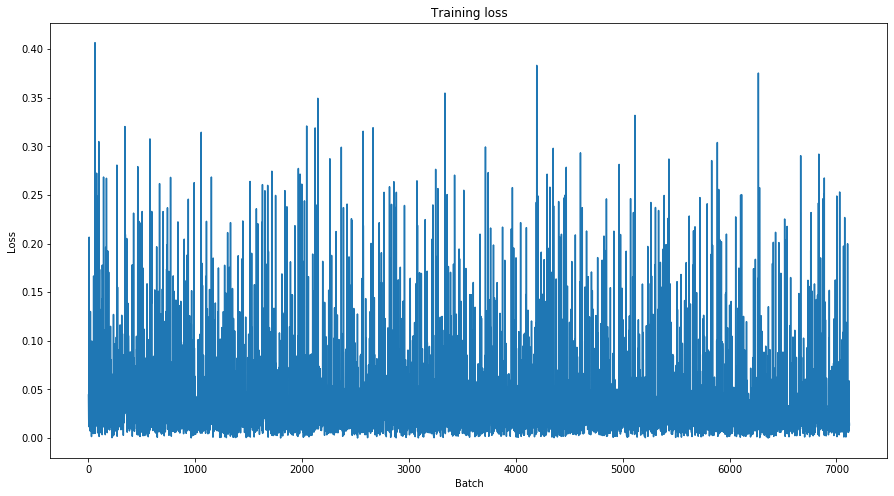

In [17]:
import time
since = time.time()

optimizer = BertAdam(model.parameters(),
                     lr=2e-5,
                     warmup=.1)

criterion =  nn.MSELoss()

# criterion = nn.CrossEntropyLoss()
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 3

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(trainLoader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_input_number, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
            
        preds = model(ids=b_input_ids.long(), mask=b_input_mask, numbers=b_input_number)
        loss = criterion(preds, b_labels.float())
        
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
#         break
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
       
    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss = 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for step, batch in enumerate(testLoader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_input_number, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(ids=b_input_ids.long(), mask=b_input_mask, numbers=b_input_number)    
            logits = torch.tensor(logits)
            loss = criterion(logits, b_labels.float())
            eval_loss += loss.item()
        label_ids = b_labels.to('cpu').numpy()
        nb_eval_steps += 1
#         break
    print('Test Loss: {}'.format(eval_loss/nb_eval_steps))
    td = time.time() - since
    print('已花時間: {:.0f}m {:.0f}s'.format(td // 60, td % 60))
    print('-'*50)

    
print('結束訓練')
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [18]:
torch.save(model.state_dict(), './myModel2.model')

In [67]:
model2 = MyModel()

In [68]:
model2.load_state_dict(torch.load('./myModel.model'))
# model2.eval()

<All keys matched successfully>

In [1]:
# model2